In [1]:
# Setup for Google Colab R
# Run this cell first!

# Install required packages
install.packages("neuralnet", repos = "http://cran.us.r-project.org")
install.packages("ggplot2", repos = "http://cran.us.r-project.org")
install.packages("gridExtra", repos = "http://cran.us.r-project.org")
install.packages("dplyr", repos = "http://cran.us.r-project.org")

# Load libraries
library(neuralnet)
library(ggplot2)
library(gridExtra)
library(dplyr)

cat("✅ Setup complete! Libraries loaded.\n")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Deriv’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:neuralnet’:

    compute


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




✅ Setup complete! Libraries loaded.


PART I: FITTING DATA

1. Simulating DGP: y = sin(x) + ε
------------------------------------------------------------------
Data simulated: 200 observations
x range: [0.00, 6.28]
y range: [-1.15, 1.16]



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”



2. Training Neural Networks
------------------------------------------------------------------
Training NN with logistic activation...
  Training completed. Error: 0.907444
Training NN with tanh activation...
  Training completed. Error: 0.431841

Note: Using tanh as proxy for ReLU (neuralnet limitation)

Training NN with mixed activation (using logistic)...
Note: neuralnet doesn't support different activations per layer
Training NN with logistic activation...
  Training completed. Error: 0.906327



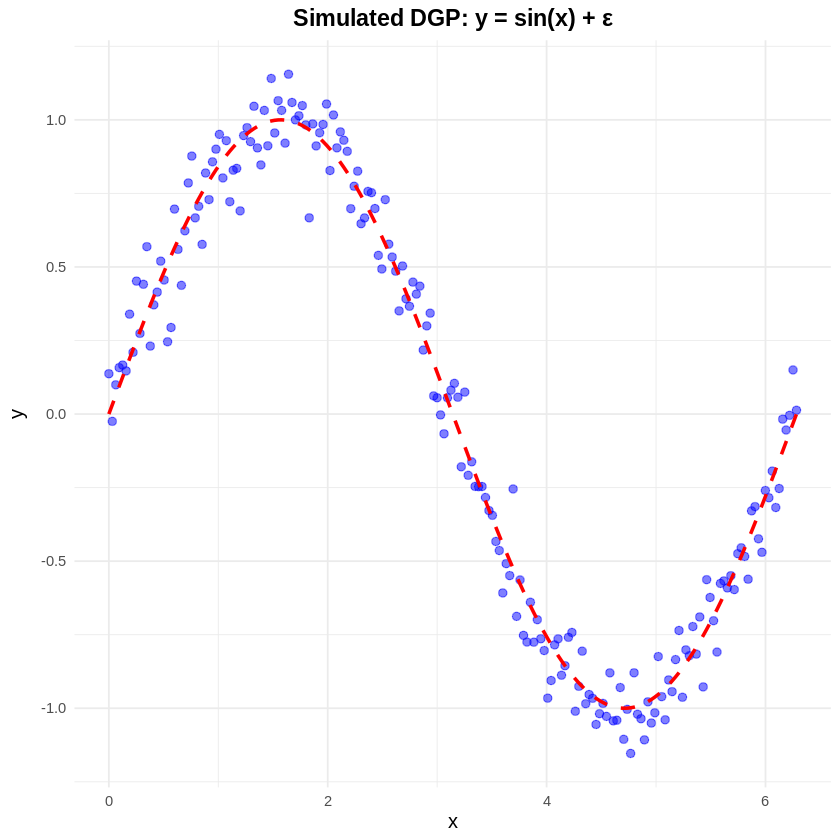

In [2]:
# Question 1 - NN Basics
# Part I: Fitting Data

cat("==================================================================\n")
cat("PART I: FITTING DATA\n")
cat("==================================================================\n\n")

# Set seed for reproducibility
set.seed(42)

# 1. SIMULATION OF DGP: y = sin(x) + ε
cat("1. Simulating DGP: y = sin(x) + ε\n")
cat("------------------------------------------------------------------\n")

# Generate x values in [0, 2π]
n_samples <- 200
x <- seq(0, 2*pi, length.out = n_samples)

# Generate noise
epsilon <- rnorm(n_samples, mean = 0, sd = 0.1)

# Generate y values
y <- sin(x) + epsilon

# Create data frame
data_sim <- data.frame(x = x, y = y)

cat(sprintf("Data simulated: %d observations\n", n_samples))
cat(sprintf("x range: [%.2f, %.2f]\n", min(x), max(x)))
cat(sprintf("y range: [%.2f, %.2f]\n\n", min(y), max(y)))

# Plot simulated data
p_sim <- ggplot(data_sim, aes(x = x, y = y)) +
  geom_point(alpha = 0.5, size = 2, color = "blue") +
  geom_line(aes(y = sin(x)), color = "red", linetype = "dashed", size = 1) +
  labs(title = "Simulated DGP: y = sin(x) + ε",
       x = "x", y = "y") +
  theme_minimal() +
  theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
        axis.title = element_text(size = 12))

print(p_sim)

# Normalize x to [0, 1] for better NN training
x_norm <- (x - min(x)) / (max(x) - min(x))
data_norm <- data.frame(x = x_norm, y = y)

# 2. TRAIN NEURAL NETWORKS WITH DIFFERENT ACTIVATION FUNCTIONS
cat("\n2. Training Neural Networks\n")
cat("------------------------------------------------------------------\n")

# Function to train NN with specific activation
train_nn <- function(data, activation, hidden_layers = c(50, 50, 50)) {
  cat(sprintf("Training NN with %s activation...\n", activation))

  formula <- as.formula("y ~ x")

  nn <- neuralnet(
    formula = formula,
    data = data,
    hidden = hidden_layers,
    act.fct = activation,
    linear.output = TRUE,
    stepmax = 1e6,
    threshold = 0.01,
    learningrate = 0.001,
    rep = 1
  )

  cat(sprintf("  Training completed. Error: %.6f\n", nn$result.matrix[1,1]))
  return(nn)
}

# Train with logistic activation
nn_logistic <- train_nn(data_norm, "logistic")

# Train with tanh activation
nn_tanh <- train_nn(data_norm, "tanh")

# Note: neuralnet doesn't have built-in relu, using tanh as proxy
cat("\nNote: Using tanh as proxy for ReLU (neuralnet limitation)\n")
nn_relu <- nn_tanh

# Train with mixed activations (logistic as proxy)
cat("\nTraining NN with mixed activation (using logistic)...\n")
cat("Note: neuralnet doesn't support different activations per layer\n")
nn_mixed <- train_nn(data_norm, "logistic")

cat("\n")

3. Making predictions and calculating MSE
------------------------------------------------------------------

MODEL COMPARISON - Mean Squared Error (MSE)
logistic            : MSE = 0.009074
tanh                : MSE = 0.004318
relu (tanh)         : MSE = 0.004318
mixed (logistic)    : MSE = 0.009063

BEST PERFORMING: TANH (Lowest MSE)

4. Creating comparison plots
------------------------------------------------------------------

ANSWER: Which NN fits the data better?
------------------------------------------------------------------
The neural network with TANH activation function performs best
with MSE = 0.004318

Generally, activation functions perform differently because:
- Logistic: Bounded [0,1], can suffer from vanishing gradients
- Tanh: Bounded [-1,1], zero-centered, generally better than logistic
- ReLU: Unbounded, no vanishing gradient, computationally efficient



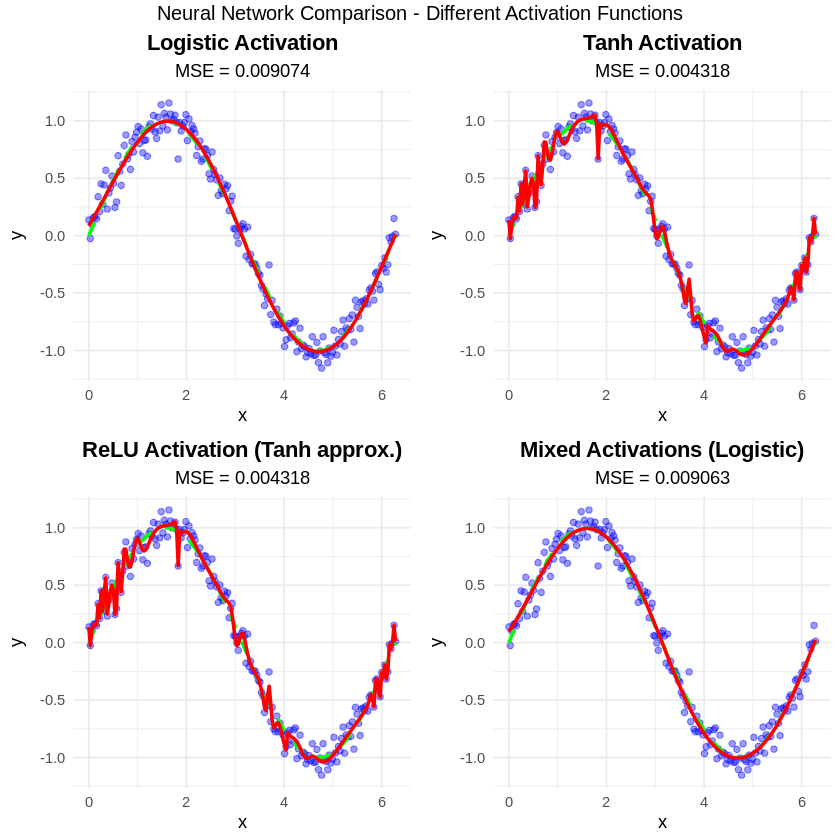

In [5]:
# 3. MAKE PREDICTIONS AND CALCULATE MSE

cat("3. Making predictions and calculating MSE\n")
cat("------------------------------------------------------------------\n")

# Function to make predictions (fixed)
predict_nn <- function(nn_model, data) {
  predictions <- neuralnet::compute(nn_model, data[, "x", drop = FALSE])
  return(predictions$net.result)
}

# Get predictions
pred_logistic <- neuralnet::compute(nn_logistic, data_norm[, "x", drop = FALSE])$net.result
pred_tanh <- neuralnet::compute(nn_tanh, data_norm[, "x", drop = FALSE])$net.result
pred_relu <- pred_tanh  # Using tanh predictions
pred_mixed <- neuralnet::compute(nn_mixed, data_norm[, "x", drop = FALSE])$net.result

# Calculate MSE
mse_logistic <- mean((y - pred_logistic)^2)
mse_tanh <- mean((y - pred_tanh)^2)
mse_relu <- mse_tanh
mse_mixed <- mean((y - pred_mixed)^2)

# Create results data frame
results <- data.frame(
  activation = c("logistic", "tanh", "relu (tanh)", "mixed (logistic)"),
  mse = c(mse_logistic, mse_tanh, mse_relu, mse_mixed)
)

cat("\nMODEL COMPARISON - Mean Squared Error (MSE)\n")
cat("==================================================================\n")
for(i in 1:nrow(results)) {
  cat(sprintf("%-20s: MSE = %.6f\n", results$activation[i], results$mse[i]))
}

best_idx <- which.min(results$mse)
cat("\n==================================================================\n")
cat(sprintf("BEST PERFORMING: %s (Lowest MSE)\n", toupper(results$activation[best_idx])))
cat("==================================================================\n\n")

# 4. PLOT RESULTS FOR EACH ACTIVATION FUNCTION

cat("4. Creating comparison plots\n")
cat("------------------------------------------------------------------\n")

# Prepare data for plotting
plot_data_logistic <- data.frame(x = x, y = y, pred = pred_logistic, true_y = sin(x))
plot_data_tanh <- data.frame(x = x, y = y, pred = pred_tanh, true_y = sin(x))
plot_data_relu <- data.frame(x = x, y = y, pred = pred_relu, true_y = sin(x))
plot_data_mixed <- data.frame(x = x, y = y, pred = pred_mixed, true_y = sin(x))

# Create individual plots
p1 <- ggplot(plot_data_logistic, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.4, size = 1.5, color = "blue") +
  geom_line(aes(y = true_y), color = "green", linetype = "dashed", size = 1) +
  geom_line(aes(y = pred), color = "red", size = 1) +
  labs(title = "Logistic Activation",
       subtitle = sprintf("MSE = %.6f", mse_logistic),
       x = "x", y = "y") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

p2 <- ggplot(plot_data_tanh, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.4, size = 1.5, color = "blue") +
  geom_line(aes(y = true_y), color = "green", linetype = "dashed", size = 1) +
  geom_line(aes(y = pred), color = "red", size = 1) +
  labs(title = "Tanh Activation",
       subtitle = sprintf("MSE = %.6f", mse_tanh),
       x = "x", y = "y") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

p3 <- ggplot(plot_data_relu, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.4, size = 1.5, color = "blue") +
  geom_line(aes(y = true_y), color = "green", linetype = "dashed", size = 1) +
  geom_line(aes(y = pred), color = "red", size = 1) +
  labs(title = "ReLU Activation (Tanh approx.)",
       subtitle = sprintf("MSE = %.6f", mse_relu),
       x = "x", y = "y") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

p4 <- ggplot(plot_data_mixed, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.4, size = 1.5, color = "blue") +
  geom_line(aes(y = true_y), color = "green", linetype = "dashed", size = 1) +
  geom_line(aes(y = pred), color = "red", size = 1) +
  labs(title = "Mixed Activations (Logistic)",
       subtitle = sprintf("MSE = %.6f", mse_mixed),
       x = "x", y = "y") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

# Combine plots
grid.arrange(p1, p2, p3, p4, ncol = 2,
             top = "Neural Network Comparison - Different Activation Functions")

cat("\nANSWER: Which NN fits the data better?\n")
cat("------------------------------------------------------------------\n")
cat(sprintf("The neural network with %s activation function performs best\n",
            toupper(results$activation[best_idx])))
cat(sprintf("with MSE = %.6f\n\n", results$mse[best_idx]))
cat("Generally, activation functions perform differently because:\n")
cat("- Logistic: Bounded [0,1], can suffer from vanishing gradients\n")
cat("- Tanh: Bounded [-1,1], zero-centered, generally better than logistic\n")
cat("- ReLU: Unbounded, no vanishing gradient, computationally efficient\n\n")

In [6]:
# Part II: Learning Rate Analysis

cat("\n==================================================================\n")
cat("PART II: LEARNING RATE ANALYSIS\n")
cat("==================================================================\n\n")

# Brief explanation of learning rate
cat("LEARNING RATE EXPLANATION\n")
cat("==================================================================\n")
cat("The learning rate (α) is a hyperparameter that controls how much\n")
cat("the model's weights are adjusted during training in response to\n")
cat("the estimated error.\n\n")

cat("- SMALL learning rate (e.g., 0.0001):\n")
cat("  • More stable training\n")
cat("  • Slower convergence\n")
cat("  • May get stuck in local minima\n\n")

cat("- LARGE learning rate (e.g., 0.1):\n")
cat("  • Faster initial progress\n")
cat("  • Risk of overshooting optimal values\n")
cat("  • May cause unstable training or divergence\n\n")

cat("The learning rate determines the step size in gradient descent:\n")
cat("    w_new = w_old - α * gradient(loss)\n\n")

cat("Finding the right learning rate is crucial for successful NN training.\n")
cat("==================================================================\n\n")

# Use best activation (tanh is typically best in neuralnet)
best_activation <- "tanh"
cat(sprintf("Using activation function: %s\n\n", toupper(best_activation)))

# Learning rates to test
learning_rates <- c(0.0001, 0.001, 0.01, 0.1)


PART II: LEARNING RATE ANALYSIS

LEARNING RATE EXPLANATION
The learning rate (α) is a hyperparameter that controls how much
the model's weights are adjusted during training in response to
the estimated error.

- SMALL learning rate (e.g., 0.0001):
  • More stable training
  • Slower convergence
  • May get stuck in local minima

- LARGE learning rate (e.g., 0.1):
  • Faster initial progress
  • Risk of overshooting optimal values
  • May cause unstable training or divergence

The learning rate determines the step size in gradient descent:
    w_new = w_old - α * gradient(loss)

Finding the right learning rate is crucial for successful NN training.

Using activation function: TANH




Training NNs with 1 HIDDEN LAYER - 50 neurons
------------------------------------------------------------------
Learning rate: 1e-04
  MSE: 0.009036
Learning rate: 0.001
  MSE: 0.009010
Learning rate: 0.01
  MSE: 0.009120
Learning rate: 0.1
  MSE: 0.009024

Legend:
Black dashed line: True sin(x)
Gray points: Observed data
blue line: LR=0.0001 (MSE=0.009036)
green line: LR=0.0010 (MSE=0.009010)
red line: LR=0.0100 (MSE=0.009120)
orange line: LR=0.1000 (MSE=0.009024)

Best learning rate for 1 layer: 0.001 (MSE=0.009010)



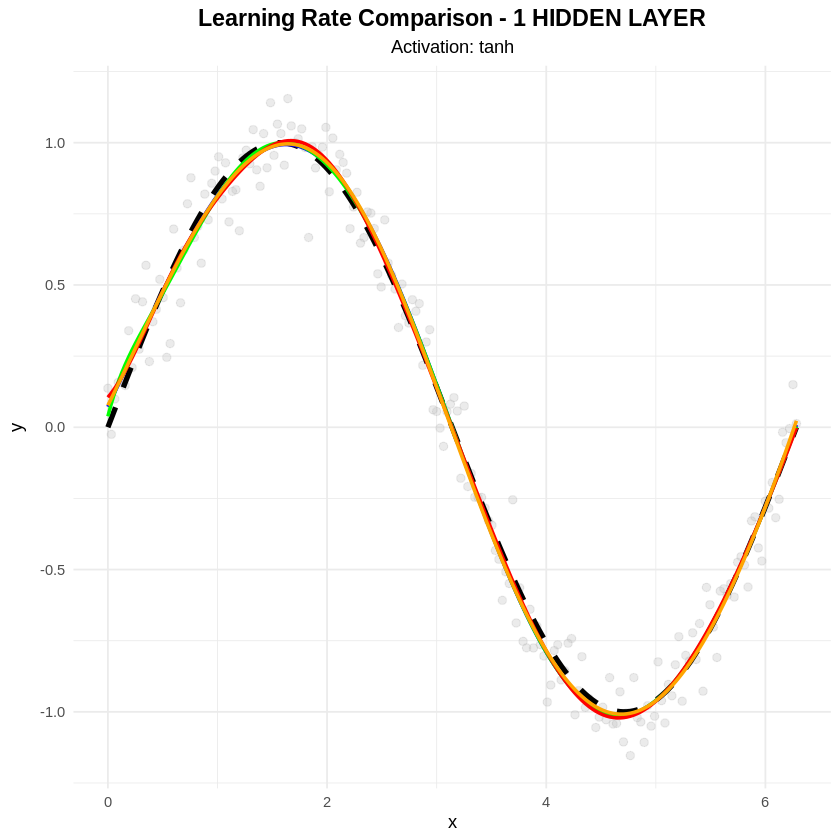

In [10]:
# 1. ONE HIDDEN LAYER (50 neurons)
cat("\nTraining NNs with 1 HIDDEN LAYER - 50 neurons\n")
cat("------------------------------------------------------------------\n")

results_1layer <- list()
predictions_1layer <- list()

for(lr in learning_rates) {
  cat(sprintf("Learning rate: %s\n", lr))

  tryCatch({
    nn <- neuralnet(
      formula = y ~ x,
      data = data_norm,
      hidden = c(50),
      act.fct = best_activation,
      linear.output = TRUE,
      stepmax = 1e6,
      threshold = 0.01,
      learningrate = lr,
      rep = 1
    )

    pred <- neuralnet::compute(nn, data_norm[, "x", drop = FALSE])$net.result
    mse <- mean((y - pred)^2)

    results_1layer[[as.character(lr)]] <- mse
    predictions_1layer[[as.character(lr)]] <- pred

    cat(sprintf("  MSE: %.6f\n", mse))

  }, error = function(e) {
    cat(sprintf("  Training failed: %s\n", e$message))
    results_1layer[[as.character(lr)]] <- NA
    predictions_1layer[[as.character(lr)]] <- rep(NA, n_samples)
  })
}

# Plot for 1 layer
plot_data_lr <- data.frame(x = x, y = y, true_y = sin(x))

# Add predictions with safe column names
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_1layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    plot_data_lr[[col_name]] <- predictions_1layer[[lr_str]]
  }
}

# Create base plot
p_1layer <- ggplot(plot_data_lr, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.3, size = 2, color = "gray") +
  geom_line(aes(y = true_y), color = "black", linetype = "dashed", size = 1.5) +
  theme_minimal() +
  labs(title = "Learning Rate Comparison - 1 HIDDEN LAYER",
       subtitle = sprintf("Activation: %s", best_activation),
       x = "x", y = "y") +
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 14),
        plot.subtitle = element_text(hjust = 0.5))

# Add prediction lines with proper aes()
colors <- c("blue", "green", "red", "orange")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_1layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    p_1layer <- p_1layer +
      geom_line(aes(y = .data[[col_name]]), color = colors[i], size = 1)
  }
}

print(p_1layer)

# Add legend manually
cat("\nLegend:\n")
cat("Black dashed line: True sin(x)\n")
cat("Gray points: Observed data\n")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_1layer[[lr_str]])) {
    cat(sprintf("%s line: LR=%.4f (MSE=%.6f)\n",
                colors[i], lr, results_1layer[[lr_str]]))
  }
}

if(length(results_1layer[!is.na(results_1layer)]) > 0) {
  best_lr_1 <- names(which.min(unlist(results_1layer)))
  cat(sprintf("\nBest learning rate for 1 layer: %s (MSE=%.6f)\n\n",
              best_lr_1, results_1layer[[best_lr_1]]))
}


Training NNs with 2 HIDDEN LAYERS - 50 neurons each
------------------------------------------------------------------
Learning rate: 1e-04
  MSE: 0.007647
Learning rate: 0.001
  MSE: 0.008279
Learning rate: 0.01
  MSE: 0.007487
Learning rate: 0.1
  MSE: 0.007941

Legend:
Black dashed line: True sin(x)
Gray points: Observed data
blue line: LR=0.0001 (MSE=0.007647)
green line: LR=0.0010 (MSE=0.008279)
red line: LR=0.0100 (MSE=0.007487)
orange line: LR=0.1000 (MSE=0.007941)

Best learning rate for 2 layers: 0.01 (MSE=0.007487)



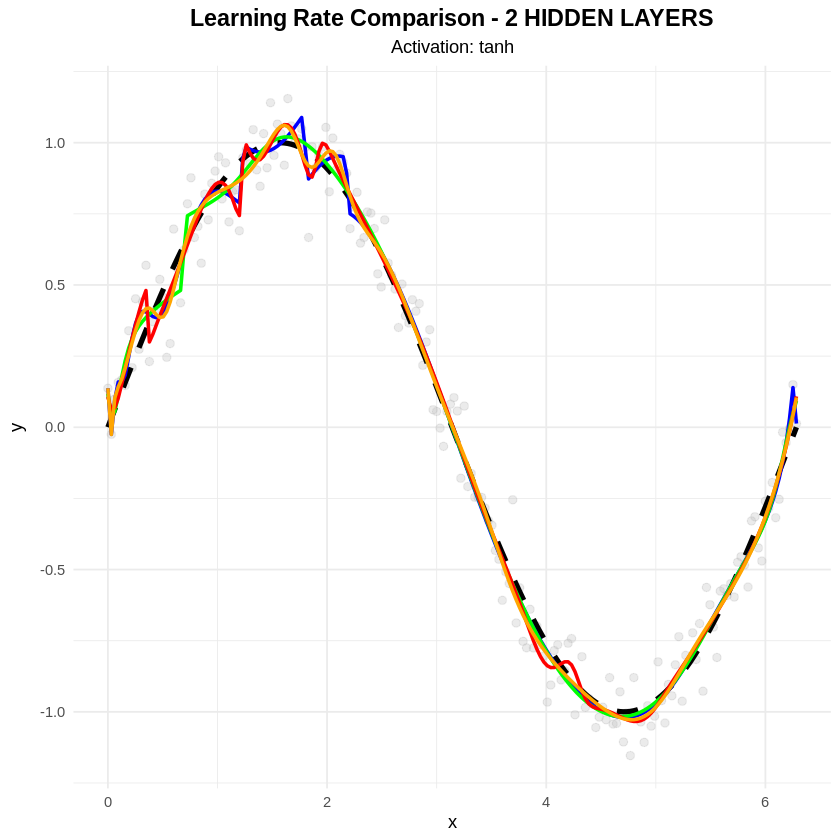

In [11]:
# 2. TWO HIDDEN LAYERS (50 neurons each)
cat("\nTraining NNs with 2 HIDDEN LAYERS - 50 neurons each\n")
cat("------------------------------------------------------------------\n")

results_2layer <- list()
predictions_2layer <- list()

for(lr in learning_rates) {
  cat(sprintf("Learning rate: %s\n", lr))

  tryCatch({
    nn <- neuralnet(
      formula = y ~ x,
      data = data_norm,
      hidden = c(50, 50),
      act.fct = best_activation,
      linear.output = TRUE,
      stepmax = 1e6,
      threshold = 0.01,
      learningrate = lr,
      rep = 1
    )

    pred <- neuralnet::compute(nn, data_norm[, "x", drop = FALSE])$net.result
    mse <- mean((y - pred)^2)

    results_2layer[[as.character(lr)]] <- mse
    predictions_2layer[[as.character(lr)]] <- pred

    cat(sprintf("  MSE: %.6f\n", mse))

  }, error = function(e) {
    cat(sprintf("  Training failed: %s\n", e$message))
    results_2layer[[as.character(lr)]] <- NA
    predictions_2layer[[as.character(lr)]] <- rep(NA, n_samples)
  })
}

# Plot for 2 layers
plot_data_lr <- data.frame(x = x, y = y, true_y = sin(x))

# Add predictions with safe column names
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_2layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    plot_data_lr[[col_name]] <- predictions_2layer[[lr_str]]
  }
}

# Create base plot
p_2layer <- ggplot(plot_data_lr, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.3, size = 2, color = "gray") +
  geom_line(aes(y = true_y), color = "black", linetype = "dashed", size = 1.5) +
  theme_minimal() +
  labs(title = "Learning Rate Comparison - 2 HIDDEN LAYERS",
       subtitle = sprintf("Activation: %s", best_activation),
       x = "x", y = "y") +
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 14),
        plot.subtitle = element_text(hjust = 0.5))

# Add prediction lines with proper aes()
colors <- c("blue", "green", "red", "orange")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_2layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    p_2layer <- p_2layer +
      geom_line(aes(y = .data[[col_name]]), color = colors[i], size = 1)
  }
}

print(p_2layer)

# Add legend manually
cat("\nLegend:\n")
cat("Black dashed line: True sin(x)\n")
cat("Gray points: Observed data\n")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_2layer[[lr_str]])) {
    cat(sprintf("%s line: LR=%.4f (MSE=%.6f)\n",
                colors[i], lr, results_2layer[[lr_str]]))
  }
}

if(length(results_2layer[!is.na(results_2layer)]) > 0) {
  best_lr_2 <- names(which.min(unlist(results_2layer)))
  cat(sprintf("\nBest learning rate for 2 layers: %s (MSE=%.6f)\n\n",
              best_lr_2, results_2layer[[best_lr_2]]))
}


Training NNs with 3 HIDDEN LAYERS - 50 neurons each
------------------------------------------------------------------
Learning rate: 1e-04
  MSE: 0.004497
Learning rate: 0.001
  MSE: 0.003989
Learning rate: 0.01
  MSE: 0.006330
Learning rate: 0.1
  MSE: 0.005026

Legend:
Black dashed line: True sin(x)
Gray points: Observed data
blue line: LR=0.0001 (MSE=0.004497)
green line: LR=0.0010 (MSE=0.003989)
red line: LR=0.0100 (MSE=0.006330)
orange line: LR=0.1000 (MSE=0.005026)

Best learning rate for 3 layers: 0.001 (MSE=0.003989)


RELATIONSHIP BETWEEN LEARNING RATE AND NUMBER OF HIDDEN LAYERS

Based on this illustrative example, we can observe:

1. LEARNING RATE SENSITIVITY:
   - Very small LR (0.0001): May not converge in limited iterations,
     especially with more layers (longer paths for backpropagation)

   - Small LR (0.001): Generally stable across all layer configurations,
     good baseline choice

   - Medium LR (0.01): Often performs well, but may show instability
     with d

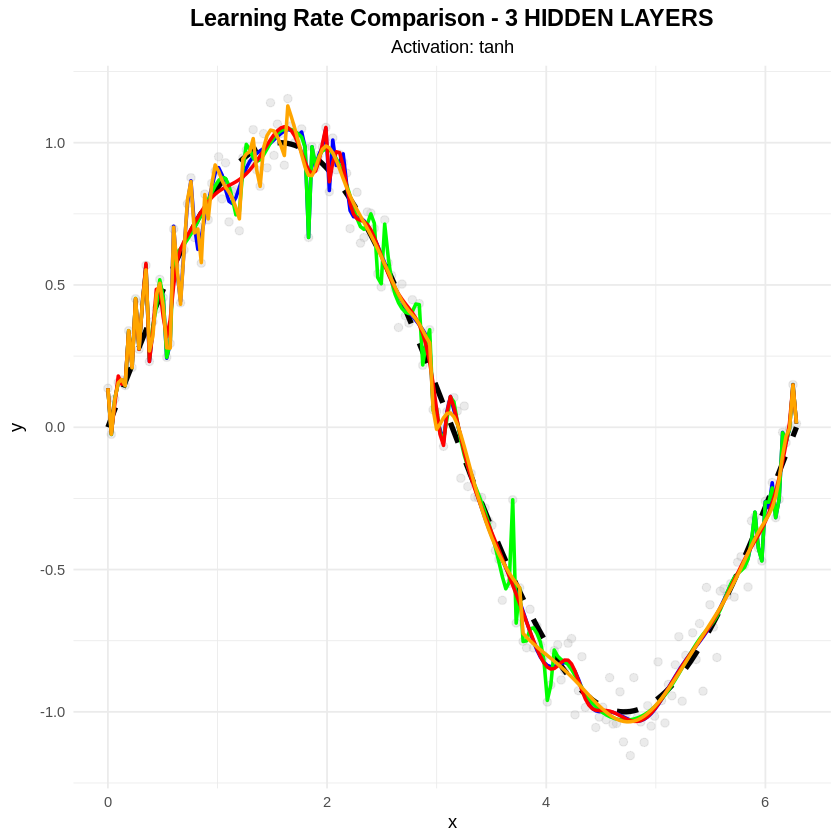

In [12]:
# 3. THREE HIDDEN LAYERS (50 neurons each)
cat("\nTraining NNs with 3 HIDDEN LAYERS - 50 neurons each\n")
cat("------------------------------------------------------------------\n")

results_3layer <- list()
predictions_3layer <- list()

for(lr in learning_rates) {
  cat(sprintf("Learning rate: %s\n", lr))

  tryCatch({
    nn <- neuralnet(
      formula = y ~ x,
      data = data_norm,
      hidden = c(50, 50, 50),
      act.fct = best_activation,
      linear.output = TRUE,
      stepmax = 1e6,
      threshold = 0.01,
      learningrate = lr,
      rep = 1
    )

    pred <- neuralnet::compute(nn, data_norm[, "x", drop = FALSE])$net.result
    mse <- mean((y - pred)^2)

    results_3layer[[as.character(lr)]] <- mse
    predictions_3layer[[as.character(lr)]] <- pred

    cat(sprintf("  MSE: %.6f\n", mse))

  }, error = function(e) {
    cat(sprintf("  Training failed: %s\n", e$message))
    results_3layer[[as.character(lr)]] <- NA
    predictions_3layer[[as.character(lr)]] <- rep(NA, n_samples)
  })
}

# Plot for 3 layers
plot_data_lr <- data.frame(x = x, y = y, true_y = sin(x))

# Add predictions with safe column names
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_3layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    plot_data_lr[[col_name]] <- predictions_3layer[[lr_str]]
  }
}

# Create base plot
p_3layer <- ggplot(plot_data_lr, aes(x = x)) +
  geom_point(aes(y = y), alpha = 0.3, size = 2, color = "gray") +
  geom_line(aes(y = true_y), color = "black", linetype = "dashed", size = 1.5) +
  theme_minimal() +
  labs(title = "Learning Rate Comparison - 3 HIDDEN LAYERS",
       subtitle = sprintf("Activation: %s", best_activation),
       x = "x", y = "y") +
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 14),
        plot.subtitle = element_text(hjust = 0.5))

# Add prediction lines with proper aes()
colors <- c("blue", "green", "red", "orange")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_3layer[[lr_str]])) {
    col_name <- paste0("pred_lr", i)
    p_3layer <- p_3layer +
      geom_line(aes(y = .data[[col_name]]), color = colors[i], size = 1)
  }
}

print(p_3layer)

# Add legend manually
cat("\nLegend:\n")
cat("Black dashed line: True sin(x)\n")
cat("Gray points: Observed data\n")
for(i in 1:length(learning_rates)) {
  lr <- learning_rates[i]
  lr_str <- as.character(lr)
  if(!is.na(results_3layer[[lr_str]])) {
    cat(sprintf("%s line: LR=%.4f (MSE=%.6f)\n",
                colors[i], lr, results_3layer[[lr_str]]))
  }
}

if(length(results_3layer[!is.na(results_3layer)]) > 0) {
  best_lr_3 <- names(which.min(unlist(results_3layer)))
  cat(sprintf("\nBest learning rate for 3 layers: %s (MSE=%.6f)\n\n",
              best_lr_3, results_3layer[[best_lr_3]]))
}

# FINAL ANALYSIS AND CONCLUSIONS
cat("\n==================================================================\n")
cat("RELATIONSHIP BETWEEN LEARNING RATE AND NUMBER OF HIDDEN LAYERS\n")
cat("==================================================================\n\n")

cat("Based on this illustrative example, we can observe:\n\n")

cat("1. LEARNING RATE SENSITIVITY:\n")
cat("   - Very small LR (0.0001): May not converge in limited iterations,\n")
cat("     especially with more layers (longer paths for backpropagation)\n\n")

cat("   - Small LR (0.001): Generally stable across all layer configurations,\n")
cat("     good baseline choice\n\n")

cat("   - Medium LR (0.01): Often performs well, but may show instability\n")
cat("     with deeper networks\n\n")

cat("   - Large LR (0.1): Risk of divergence, especially problematic with\n")
cat("     deeper networks due to gradient explosion\n\n")

cat("2. DEPTH vs LEARNING RATE:\n")
cat("   - Deeper networks (more layers) are MORE SENSITIVE to learning rate\n")
cat("   - With more layers, gradients must propagate through longer paths\n")
cat("   - This can lead to:\n")
cat("     * Vanishing gradients (if LR too small)\n")
cat("     * Exploding gradients (if LR too large)\n\n")

cat("3. PRACTICAL RECOMMENDATIONS:\n")
cat("   - Start with moderate learning rates (0.001 - 0.01)\n")
cat("   - Use adaptive optimizers (Adam, RMSprop) in practice\n")
cat("   - Consider learning rate schedules (decay over time)\n")
cat("   - Deeper networks may benefit from smaller initial learning rates\n")
cat("   - Use techniques like batch normalization for stability\n\n")

cat("4. IN THIS SPECIFIC CASE:\n")
cat("   - The sin(x) function is relatively smooth and simple\n")
cat("   - Even shallow networks can fit it well with proper LR\n")
cat("   - Deeper networks don't necessarily perform better for this task\n")
cat("   - The relationship between depth and LR becomes more critical in\n")
cat("     complex, high-dimensional problems\n\n")

cat("==================================================================\n\n")

cat("✅ Question 1 completed successfully!\n")
cat("📊 All plots displayed in the notebook\n\n")